# Анализ поведения пользователей мобильного приложения

Предстоит выяснить, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? Понадобится анализ воронки продаж.

Также, ислледование включает анализ результатов A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить какой шрифт лучше, используя инструменты для статистического и исследовательского анализа.

Описание данных:
1. EventName — название события;
2. DeviceIDHash — уникальный идентификатор пользователя;
3. EventTimestamp — время события;
4. ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Предобработка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import warnings
import math as mth
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
from scipy import stats as st

In [2]:
# загрузим и ознакомимься с данными

data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
# Просмотрим информацию по датасету
data.info()
print('Количество дубликатов:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Количество дубликатов: 413


В данных отсутсвуют пропуски, но присутствуют дубликаты, от которых необходимо избавиться. Также, переведем название столбцов к единому регистру. Необходимо изменить тип данных для некоторых столбцов.

In [4]:
# Изменим ригистр, удалим дубликаты

data.columns = map(str.lower, data.columns)

data = data.drop_duplicates()
data.head(5)

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# сменим типы 
warnings.filterwarnings("ignore")

data['eventtimestamp'] = pd.to_datetime(data['eventtimestamp'], unit='s')
data['deviceidhash'] = data['deviceidhash'].astype(str)
data['eventname'] = data['eventname'].astype(str)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       243713 non-null  object        
 1   deviceidhash    243713 non-null  object        
 2   eventtimestamp  243713 non-null  datetime64[ns]
 3   expid           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 9.3+ MB


In [6]:
# добавим столбец с датой
data['date'] = data['eventtimestamp'].dt.date.astype('datetime64[D]')
data.head(5)

,eventname,deviceidhash,eventtimestamp,expid,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [7]:
# Проверим пересекаются ли пользователи в разных группах
group_246 = data.query('expid == 246')
group_247 = data.query('expid == 247')
group_248 = data.query('expid == 248')

cross_246 = 0
for i in group_246:
    if i in group_247['deviceidhash'].unique() or i in group_248['deviceidhash'].unique():
        cross_246 +=1
cross_246

cross_247 = 0
for i in group_247:
    if i in group_248['deviceidhash'].unique():
        cross_247 +=1

print(cross_246)
print(cross_247)

0
0


**Вывод:**В результате предобработки были изменены типы данных, удалены дубликаты и изменены названия столбцов. Также, пересечение между пользователями в разных группах не обнаружены.

### Изучение и проверка данных

In [8]:
# Узнаем сколько всего событий в логе
print(data['eventname'].unique())
print(len(data['eventname']))

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
243713


Всего 243713 событий в данных, из них всего 5 видов, предположительно следующие: Появление на главном экране, Экран успешной транзакции, Экран корзины, Экран заказа и Экран с инструкцией

In [9]:
# Узнаем сколько всего пользователей в логе
data['deviceidhash'].value_counts()

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
5138854326043201424       1
6936517579657223951       1
4096007885698937181       1
176222176030858478        1
2408195006658927235       1
Name: deviceidhash, Length: 7551, dtype: int64

Всего в логе 7551 пользователь

In [10]:
# Узнаем сколько в среднем событий приходится на пользователя
av_events = data.pivot_table(index='deviceidhash',values='eventname',aggfunc='count')
av_events.mean().round(2)

eventname    32.28
dtype: float64

В среднем, на одного пользователя приходится 32 события

In [11]:
# Определим минимальную и максимальную дату 
print(data['date'].min())
print(data['date'].max())

2019-07-25 00:00:00
2019-08-07 00:00:00


Период начинается с 25го июля 2019 года и заканчивается 7го августа 2019 года

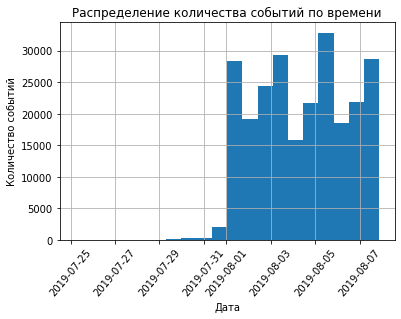

In [12]:
# Построим гистограмму по дате и времени 
data['eventtimestamp'].hist(bins = 20).set_title('Распределение количества событий по времени')
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.xticks(rotation=50) 
plt.show()


Данные за период с 25 июля по 30 июля практически отсутсвуют. Наиболее показательным периодом кажется первая неделя августа. Необходимо проверить много ли данных мы отбросим, если начнем исследование с 1го августа.

In [13]:
# Проверим сколько событий и пользователей мы отбросили после фильтрации

new_data = data.query('date > "2019-07-31"') # датасет для дальнейшей работы

filtr_data = data.query('date <= "2019-07-31"')
miss_id = 0
for i in filtr_data:
    if i not in filtr_data['deviceidhash'].unique():
        miss_id +=1 
user_cnt_before = data['deviceidhash'].unique()
user_cnt_after = new_data['deviceidhash'].unique()

print('Отфильтровано событий:', len(filtr_data['eventname']))
print('Доля:', round((len(filtr_data['eventname']) / len(data['eventname'])*100), 2), '%')
print('Отфильтровано пользователей:', len(user_cnt_before) - len(user_cnt_after))
print('Доля:', round((len(user_cnt_before) - len(user_cnt_after)) / len(user_cnt_before*100), 4), '%')

Отфильтровано событий: 2826
Доля: 1.16 %
Отфильтровано пользователей: 17
Доля: 0.0023 %


In [14]:
# Убедимся, что оставшиеся пользователи после фильтрации входят во все 3 группы
new_data['expid'].value_counts()


248    84563
246    79302
247    77022
Name: expid, dtype: int64

**Вывод:**В результате проверки отфильтрован период исследования. Отбросили не показательные данные за период до 1 августа 2019 года.

### Изучение воронки событий

In [15]:
# Выведем данные 
new_data.head(5)

,eventname,deviceidhash,eventtimestamp,expid,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [16]:
# Просмотрим какие события чаще всего встречаются в логах
new_data['eventname'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventname, dtype: int64

Чаще всего пользователи появляются на главном экране, далее на странице заказа, в корзине, реже на странице оплаты и совсем редко на странице с инструкцией.

In [17]:
# Посчитаем сколько пользователей совершали каждое из этих действий 
data_av_id = new_data.pivot_table(index='eventname',values='deviceidhash',aggfunc='nunique')\
.sort_values(by = 'deviceidhash', ascending = False)
data_av_id

,deviceidhash
eventname,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [18]:
#Посчитаем долю пользователей, которые хоть раз совершали событие

data_av_id['v/v'] = round(data_av_id['deviceidhash']/len(new_data['deviceidhash'].unique()), 3)
data_av_id

,deviceidhash,v/v
eventname,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


Практически все пользователи, которые скачали приложение появляются на главном экране - 98.5%. Лишь 61% переходит к экрану с заказами, меньше 50% добавляют что-то в корзину и практически столько же оплачивают заказ. Экран с инструкцией кажется лишним в этой цепочке, не влияющим на намерение пользователя перейти к покупкам.

In [19]:
# Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

data_av_id['conv'] = 0
for i in range(0, len(data_av_id['v/v'])):
    if i == 0:
        data_av_id['conv'].iloc[i] = 100
    else:
        data_av_id['conv'].iloc[i] = round(int(data_av_id['deviceidhash'].iloc[i])\
    / int(data_av_id['deviceidhash'].iloc[i-1]), 2)*100
data_av_id = data_av_id[data_av_id['conv']> 24]        
data_av_id

,deviceidhash,v/v,conv
eventname,,,
MainScreenAppear,7419,0.985,100
OffersScreenAppear,4593,0.610,62
CartScreenAppear,3734,0.496,81
PaymentScreenSuccessful,3539,0.470,95


Наибольшая потеря пользователей происходит после перехода с главного экрана к заказу, так более трети пользователей теряется при переходе к заказам. 82% оставшихся пользователей переходят на экран с корзиной и практически все из них (95%) доводят заказ до покупки.

In [21]:
# Посчитаем какая доля пользователей доходит от первого события до оплаты
round(data_av_id['deviceidhash'].iloc[3]/data_av_id['deviceidhash'].iloc[0], 2)*100


48.0

48% пользователей доходит от первого события до оплаты

**Вывод:** Меньше половины пользователей, которые скачали приложения доходят до оплаты заказа. При этом, наибольшая часть пользователей теряется при переходе от главного экрана к заказам.

### Изучение результатов A/A/B теста

In [22]:
# Посмотрим, сколько пользователей в каждой группе эксперимента
test_data = new_data.pivot_table(index='expid',values='deviceidhash',aggfunc='nunique')
test_data

,deviceidhash
expid,
246,2484
247,2513
248,2537


Группа 246 содержит 2484 пользователей, группа 247 содержит 2513 пользователей, а экспериментальная группа 248 содержит 2537 пользователей.

In [23]:
#Создадим таблицу с числом уникальных пользователей по событиям в контрольных группах
data_unique = new_data.pivot_table(index='expid',columns = 'eventname', values='deviceidhash',aggfunc='nunique')
del data_unique['Tutorial'] # уберем событие с инструкцией
data_unique['gen'] = test_data['deviceidhash']
data_unique

eventname,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,gen
expid,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


**Проверка гипотезы о равенстве долей в двух выборках** 

```

H_0: Доля пользователей группы 246 = Доля пользователей группы 247`
H_1: Доля пользователей группы 246 ≠ Доля пользователей группы 247`
alpha = 0.01
```

In [24]:
# создадим функцию для проверки гипотез

def return_hypothesis_test (success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [25]:
# введем функцию для отображения результатов, которая на вход получает порядковый номер группы в таблице и параметр альфа
def result (group1, group2, alpha):
    alpha_test = alpha
    count_users = ([data_unique['gen'][group1], data_unique['gen'][group2]])
    count_MainScreenAppear = ([data_unique['MainScreenAppear'][group1], data_unique['MainScreenAppear'][group2]])
    count_OffersScreenAppear = ([data_unique['OffersScreenAppear'][group1], data_unique['OffersScreenAppear'][group2]])
    count_CartScreenAppear = ([data_unique['CartScreenAppear'][group1], data_unique['CartScreenAppear'][group2]])
    count_PaymentScreenSuccessful = ([data_unique['PaymentScreenSuccessful'][group1], data_unique['PaymentScreenSuccessful'][group2]])
    
    print('Результаты теста по долям count_users и count_MainScreenAppear для групп')
    return_hypothesis_test(count_MainScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_OffersScreenAppear и count_users для групп')
    return_hypothesis_test(count_OffersScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_users и count_CartScreenAppear для групп')
    return_hypothesis_test(count_CartScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп')
    return_hypothesis_test(count_PaymentScreenSuccessful, count_users, alpha_test)

In [26]:
# проверим тест А/А
result (246, 247, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Самым популярным событием является появление пользователей на глвном экране. Разбиение на группы работает корректно, нельзя считать, что доли пользователей в группах 246 и 247 разные.

**Проверка гипотезы о равенстве долей в двух выборках** 

```

H_0: Доля пользователей группы 246 = Доля пользователей группы 248`
H_1: Доля пользователей группы 246 ≠ Доля пользователей группы 248`
alpha = 0.01
```

In [27]:
# проверим тест 246/248
result (246, 248, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [28]:
# Проверим насколько отличаются доли
print(round(data_unique['CartScreenAppear'].iloc[0]/data_unique['gen'].iloc[1], 2)*100)
print(round(data_unique['CartScreenAppear'].iloc[2]/data_unique['gen'].iloc[2], 2)*100)

50.0
48.0


Между долями count_users и count_CartScreenAppear для групп 246 и 248 есть разница в 2%.

**Проверка гипотезы о равенстве долей в двух выборках** 

```

H_0: Доля пользователей группы 247 = Доля пользователей группы 248`
H_1: Доля пользователей группы 247 ≠ Доля пользователей группы 248`
alpha = 0.01
```

In [29]:
# проверим тест 247/248
result (247, 248, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Разница отсутствует

**Проверка гипотезы о равенстве долей в двух выборках** 

```

H_0: Доля пользователей объединенной группы 246 и 247 = Доля пользователей группы 248`
H_1: Доля пользователей объединенной группы 246 и 247 ≠ Доля пользователей группы 248`
alpha = 0.01
```

In [30]:
# объединим группы 246 и 247 
data_unique.loc['new'] = [data_unique['CartScreenAppear'][246]+data_unique['CartScreenAppear'][247]\
                      , data_unique['MainScreenAppear'][246]+data_unique['MainScreenAppear'][247]\
                      , data_unique['OffersScreenAppear'][246]+data_unique['OffersScreenAppear'][247]\
                      , data_unique['PaymentScreenSuccessful'][246]+data_unique['PaymentScreenSuccessful'][247]\
                      , data_unique['gen'][246]+data_unique['gen'][247]]
data_unique

eventname,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,gen
expid,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
new,2504,4926,3062,2358,4997


In [31]:
# проверим тест new/248
result ('new', 248, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Разница в долях в экспериментальной и объединенной группах отсутсвуют. В результате, различия наблюдаются лишь в группах 246 и 248 в событии при переходе к корзине. Необходимо проверить, изменится ли результат теста при смене уровня статистической значимости.

In [32]:
# Проверим все вышеописанные гипотезы при alpha = 5%
# проверим тест А/А
result (246, 247, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [33]:
# проверим тест 246/248
result (246, 248, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [34]:
# проверим тест 247/248
result (247, 248, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [35]:
# проверим тест new/248
result ('new', 248, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** При уровне статистической значимости 5% все доли, во всех группах одинаковые. Всего было проведено 4 проверки гипотезы для 4 событий, при данной статистической значимости еще 16 при alpha = 0.1. В результате образуется вероятность ложнопозитивного результата при таком большом количестве тестов. Необходимо ввести поправку и проверить гипотезы с ее учетом.

In [36]:
# введем поправку по методу Шидака
alpha_cor = 1 - (1-0.05)** (1/32)
alpha_cor

0.0016016314667719467

In [37]:
# проверим тест А/А
result (246, 247, alpha_cor)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
# проверим тест 246/248
result (246, 248, alpha_cor)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
# проверим тест 247/248
result (247, 248, alpha_cor)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
# проверим тест new/248
result ('new', 248, alpha_cor)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** После ввода поправки Шидака результаты не изменились.

### Общий вывод

В результате анализа воронки продаж выяснили, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах?

Также, проанализировав результаты A/A/B-эксперимента получили заключение о необходимости изменения шрифта.

**Выводы:**
1. Всего в исследовании участвует 7551 пользователь;
2. В среднем, на одного пользователя приходится 32 события;
3. Данные за период с 25 июля по 30 июля практически отсутствуют. Наиболее показательным периодом является первая неделя августа;
4. Чаще всего пользователи появляются на главном экране, далее на странице заказа, в корзине, реже на странице оплаты и совсем редко на странице с инструкцией;
5. Практически все пользователи, которые скачали приложение появляются на главном экране - 98.5%. Лишь 61% переходит к экрану с заказами, меньше 50% добавляют что-то в корзину и практически столько же оплачивают заказ. Экран с инструкцией кажется лишним в этой цепочке, не влияющим на намерение пользователя перейти к покупкам;
6. Наибольшая потеря пользователей происходит после перехода с главного экрана к заказу, так более трети пользователей теряется при переходе к заказам. 82% оставшихся пользователей переходят на экран с корзиной и практически все из них (95%) доводят заказ до покупки;
7. 48% пользователей доходит от первого события до оплаты; 
8. Самым популярным событием является появление пользователей на главном экране;
9. Доля пользователей при уровне статистической значимости 5% во всех группах одинаковое. Однако при смене уровня к 1% наблюдается снижение в долях пользователей при переходе к корзине в экспериментальной группе и контрольной. Таким образом, изменение шрифта не приведет к позитивной динамике пользователей и лучше оставить шрифты в прежнем варианте.